In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


df = pd.read_excel('/content/drive/MyDrive/processed_stock_data.xlsx')
df["Date"] = pd.to_datetime(df[["Year", "Month", "Day"]])
df.set_index("Date", inplace=True)
df.index = pd.date_range(start=df.index[0], periods=len(df), freq='D')

In [30]:
df.tail()

,Adj Close,Close,High,Low,Open,Volume,Year,Month,Day,Timestamp,...,RSI,MACD,MACD_Signal,Stoch_K,Stoch_D,ATR,ADX,+DI,-DI,Close_+5d
2011-02-04,175.860001,175.860001,176.270004,175.050003,176.169998,225800.0,2024,12,13,1734048000,...,52.072929,0.650189,0.309240,82.805822,82.583146,2.452802,8.500777,30.993130,29.576496,178.169998
2011-02-05,174.250000,174.250000,174.970001,173.850006,174.570007,327400.0,2024,12,16,1734307200,...,48.390736,0.490943,0.345580,69.092779,78.059006,2.421173,8.154133,29.155296,31.362852,180.449997
2011-02-06,173.279999,173.279999,174.630005,173.279999,174.000000,421000.0,2024,12,17,1734393600,...,46.267952,0.283203,0.333105,56.364260,69.420954,2.344661,8.032215,27.956224,31.809481,181.429993
2011-02-07,173.619995,173.619995,179.369995,173.550003,177.330002,457900.0,2024,12,18,1734480000,...,47.143199,0.144339,0.295352,46.735598,57.397546,2.612185,8.567859,36.261961,26.512339,197.360001
2011-02-08,174.210007,174.210007,175.800003,173.770004,174.860001,404500.0,2024,12,19,1734566400,...,48.704714,0.080964,0.252474,34.333722,45.811193,2.581315,9.065242,34.074500,24.913013,199.520004


In [31]:
y = df['Close_+5d']
X = df.drop('Close_+5d', axis=1)

train_size = int(len(df) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [32]:
features = X.columns.tolist()
features

['Adj Close',
 'Close',
 'High',
 'Low',
 'Open',
 'Volume',
 'Year',
 'Month',
 'Day',
 'Timestamp',
 'Daily_Variation',
 'Daily_Return',
 'Cumulative_Return',
 '7-Day_SMA',
 '7-Day_STD',
 'SMA+2STD',
 'SMA-2STD',
 'High_Close',
 'Low_Open',
 '14-Day_EMA',
 'Close_Change',
 'Close_%Change',
 'RSI',
 'MACD',
 'MACD_Signal',
 'Stoch_K',
 'Stoch_D',
 'ATR',
 'ADX',
 '+DI',
 '-DI']

### LR , RF

In [33]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Initialize the models
lr_model = LinearRegression()
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the models
lr_model.fit(X_train, y_train)
rf_model.fit(X_train, y_train)

# Predict on test set
y_pred_lr = lr_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Evaluate the models
lr_mae = mean_absolute_error(y_test, y_pred_lr)
lr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_lr))

rf_mae = mean_absolute_error(y_test, y_pred_rf)
rf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_rf))

# Print the evaluation metrics
print(f"Linear Regression MAE: {lr_mae:.2f}, RMSE: {lr_rmse:.2f}")
print(f"Random Forest MAE: {rf_mae:.2f}, RMSE: {rf_rmse:.2f}")

Linear Regression MAE: 3.52, RMSE: 5.03
Random Forest MAE: 17.88, RMSE: 29.61


 lower MAE/RMSE indicates better model performance.

 So Linear Regression is better than RF


#### Actual vs. Predicted for Test Data

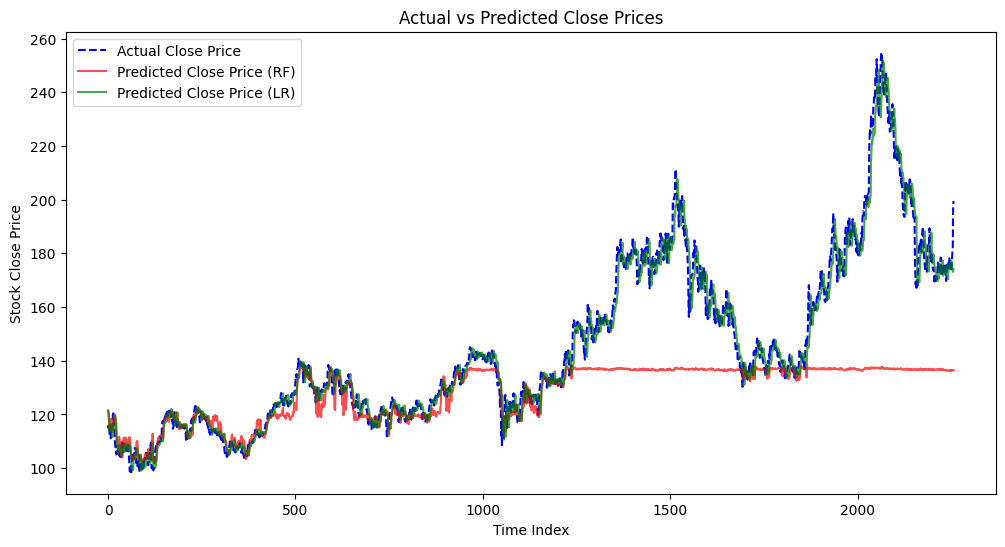

In [34]:

plt.figure(figsize=(12, 6))
plt.plot(y_test.values, label="Actual Close Price", color='blue', linestyle='dashed')
plt.plot(y_pred_rf, label="Predicted Close Price (RF)", color='red', alpha=0.7)
plt.plot(y_pred_lr, label="Predicted Close Price (LR)", color='green', alpha=0.7)
plt.xlabel("Time Index")
plt.ylabel("Stock Close Price")
plt.title("Actual vs Predicted Close Prices")
plt.legend()
plt.show()

### XGB

In [35]:
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits=5)
for train_index, test_index in tscv.split(X):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

model = xgb.XGBRegressor(objective="reg:squarederror", n_estimators=100, learning_rate=0.1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print("MAE:", mean_absolute_error(y_test, y_pred))
print("RMSE:", np.sqrt(mean_squared_error(y_test, y_pred)))

MAE: 21.967980969755494
RMSE: 33.60725387562052


#### Actual vs. Predicted for Test Data for XGB

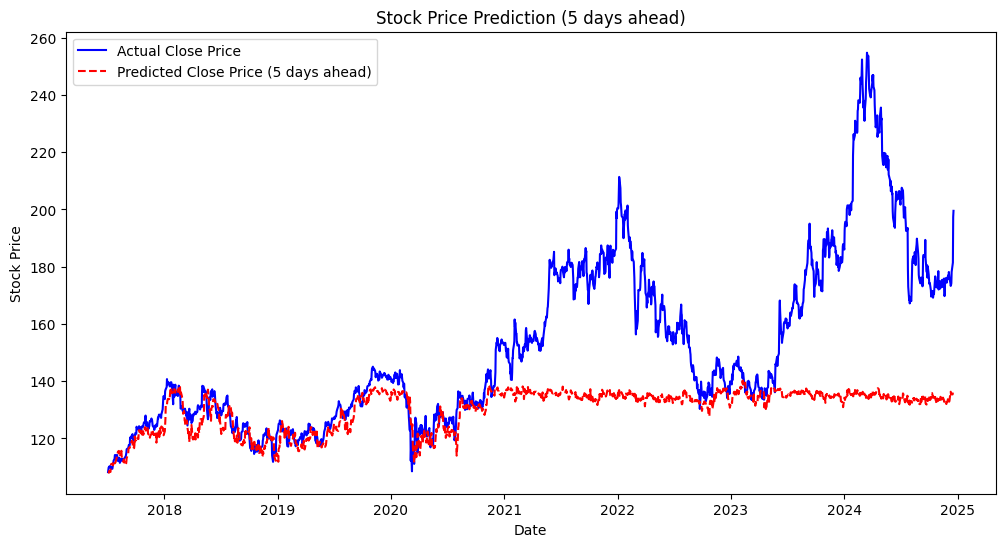

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label="Actual Close Price", color="blue")
plt.plot(y_test.index, y_pred, label="Predicted Close Price (5 days ahead)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction (5 days ahead)")
plt.legend()
plt.show()

In [37]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print("MAE:", mae)
print("RMSE:", rmse)

MAE: 20.922911584468554
RMSE: 32.43522317385819


#### LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
# Select Features
features = ["Adj Close", "High", "Low", "Open", "Volume", "RSI", "MACD", "ATR"]
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df[features])

# Prepare Target Variable
y = df["Close_+5d"].values.reshape(-1, 1)
y_scaler = MinMaxScaler()
y_scaled = y_scaler.fit_transform(y)

In [ ]:
def create_sequences(data, target, time_steps=60):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i : i + time_steps])
        y.append(target[i + time_steps])
    return np.array(X), np.array(y)

# Create sequences
time_steps = 60
X, y = create_sequences(df_scaled, y_scaled, time_steps)

# Train-Test Split (Last 10% for testing)
train_size = int(len(X) * 0.9)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [ ]:
LSTM = Sequential([
    LSTM(50, return_sequences=True, input_shape=(time_steps, len(features))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

LSTM.compile(optimizer="adam", loss="mse")
LSTM.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                        │ (None, 60, 50)              │          11,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 60, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              26 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 33,301 (130.08 KB)

 Trainable params: 33,301 (130.08 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = LSTM.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0071 - val_loss: 0.0063
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 6.9404e-04 - val_loss: 0.0020
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 5.1721e-04 - val_loss: 0.0023
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.1650e-04 - val_loss: 0.0033
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - loss: 3.7849e-04 - val_loss: 0.0026
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.6512e-04 - val_loss: 0.0019
Epoch 7/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.5299e-04 - val_loss: 0.0017
Epoch 8/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 3.5317e-04 - val_loss: 0.0017
Epoch 9/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.7318e-04 - val_loss: 0.0023
Epoch 10/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.4150e-04 - val_loss: 0.0053
Epoch 11/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 3.6454e-04 - val_loss: 0.0032
Epoch 1

In [ ]:
y_pred_scaled = LSTM.predict(X_test)
y_pred = y_scaler.inverse_transform(y_pred_scaled)
y_test_actual = y_scaler.inverse_transform(y_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


#### Actual vs Predicted LSTM

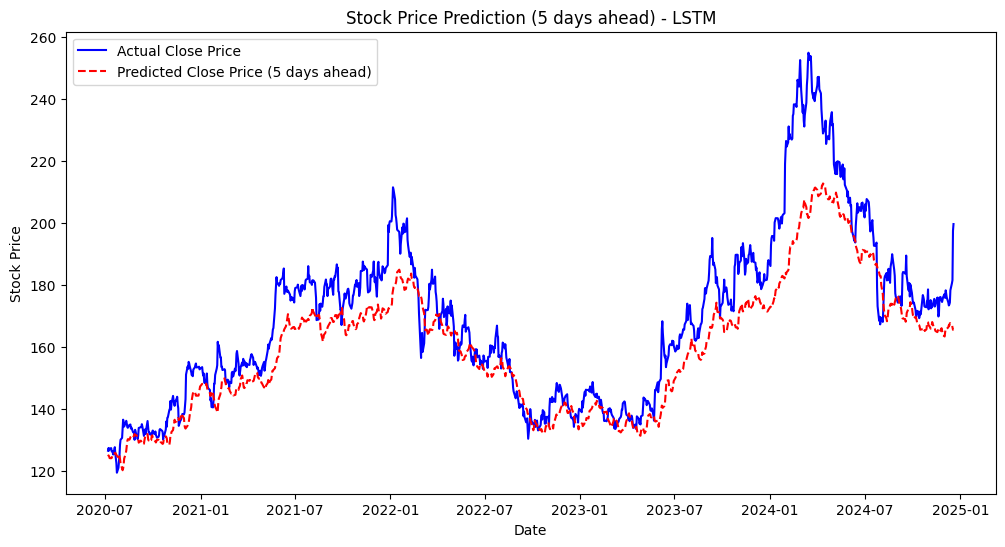

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual, label="Actual Close Price", color="blue")
plt.plot(df.index[-len(y_pred):], y_pred, label="Predicted Close Price (5 days ahead)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction (5 days ahead) - LSTM")
plt.legend()
plt.show()


### GRU

In [ ]:
from tensorflow.keras.layers import Input, GRU

In [ ]:
gru_model = Sequential([
    Input(shape=(time_steps, len(features))),  # Use Input layer with shape argument
    GRU(50, return_sequences=True),
    Dropout(0.2),
    GRU(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])
gru_model.compile(optimizer="adam", loss="mse")

In [ ]:
gru_history = gru_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 10ms/step - loss: 0.0126 - val_loss: 0.0016
Epoch 2/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 8.1443e-04 - val_loss: 0.0013
Epoch 3/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 5.3141e-04 - val_loss: 0.0018
Epoch 4/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 4.7308e-04 - val_loss: 0.0026
Epoch 5/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 4.0703e-04 - val_loss: 0.0019
Epoch 6/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 3.6913e-04 - val_loss: 0.0024
Epoch 7/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.5672e-04 - val_loss: 0.0023
Epoch 8/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 3.5260e-04 - val_loss: 0.0022
Epoch 9/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.4757e-04 - val_loss: 0.0038
Epoch 10/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.1597e-04 - val_loss: 0.0036
Epoch 11/20
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.3688e-04 - val_loss: 0.0024
Epoch 1

In [ ]:
lstm_pred = LSTM.predict(X_test)
gru_pred = gru_model.predict(X_test)

lstm_pred_actual = y_scaler.inverse_transform(lstm_pred)
gru_pred_actual = y_scaler.inverse_transform(gru_pred)
y_test_actual = y_scaler.inverse_transform(y_test)

lstm_mae = mean_absolute_error(y_test_actual, lstm_pred_actual)
lstm_rmse = np.sqrt(mean_squared_error(y_test_actual, lstm_pred_actual))

gru_mae = mean_absolute_error(y_test_actual, gru_pred_actual)
gru_rmse = np.sqrt(mean_squared_error(y_test_actual, gru_pred_actual))

print(f"LSTM - MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")
print(f"GRU  - MAE: {gru_mae:.4f}, RMSE: {gru_rmse:.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
LSTM - MAE: 9.9441, RMSE: 13.3185
GRU  - MAE: 11.2782, RMSE: 14.4844


#### Actual vs Predicted LSTM GRU

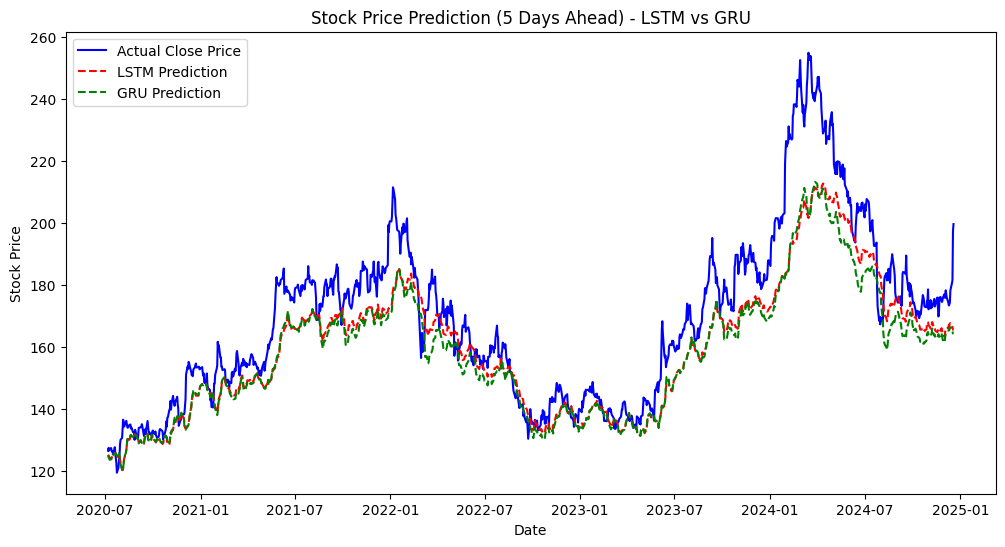

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], y_test_actual, label="Actual Close Price", color="blue")
plt.plot(df.index[-len(lstm_pred_actual):], lstm_pred_actual, label="LSTM Prediction", color="red", linestyle="dashed")
plt.plot(df.index[-len(gru_pred_actual):], gru_pred_actual, label="GRU Prediction", color="green", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction (5 Days Ahead) - LSTM vs GRU")
plt.legend()
plt.show()

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 35.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 8.3 MB/s eta 0:00:00


#### Hypertuning

In [ ]:
import optuna
from tensorflow.keras.optimizers import Adam

In [ ]:
import optuna
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam

def objective(trial):
    units_1 = trial.suggest_int("units_1", 32, 128, step=16)
    units_2 = trial.suggest_int("units_2", 32, 128, step=16)
    dropout_1 = trial.suggest_float("dropout_1", 0.1, 0.5)
    dropout_2 = trial.suggest_float("dropout_2", 0.1, 0.5)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)

    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = LSTM(units=units_1, return_sequences=True)(inputs)
    x = Dropout(dropout_1)(x)
    x = LSTM(units=units_2, return_sequences=False)(x)
    x = Dropout(dropout_2)(x)
    x = Dense(25)(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)

    model.compile(optimizer=Adam(learning_rate=learning_rate), loss="mse")

    history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test), verbose=0)

    val_loss = history.history["val_loss"][-1]
    return val_loss

In [87]:
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)

best_params = study.best_params
print(f"Best Parameters: {best_params}")

[I 2025-03-09 21:26:57,745] A new study created in memory with name: no-name-c138f577-99d6-41ab-9f07-6298b0bd544a
<ipython-input-85-c06fc77bcca1>:12: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  learning_rate = trial.suggest_loguniform("learning_rate", 1e-5, 1e-2)
[I 2025-03-09 21:27:41,465] Trial 0 finished with value: 0.0017586423782631755 and parameters: {'units_1': 48, 'units_2': 80, 'dropout_1': 0.18628631564570874, 'dropout_2': 0.49312287159353474, 'learning_rate': 1.5579652969197783e-05}. Best is trial 0 with value: 0.0017586423782631755.
[I 2025-03-09 21:28:38,510] Trial 1 finished with value: 0.004078582860529423 and parameters: {'units_1': 32, 'units_2': 96, 'dropout_1': 0.27558716113267845, 'dropout_2': 0.3286879396364579, 'learning_rate': 0.001668603916961749}. Best is trial 0 with value: 0.0017586423782631755.
[I 

Best Parameters: {'units_1': 64, 'units_2': 112, 'dropout_1': 0.21053561005616978, 'dropout_2': 0.24522707827723822, 'learning_rate': 0.0004930015415459102}


In [88]:
best_units_1 = best_params['units_1']
best_units_2 = best_params['units_2']
best_dropout_1 = best_params['dropout_1']
best_dropout_2 = best_params['dropout_2']
best_learning_rate = best_params['learning_rate']

bestLSTM = Sequential([
    LSTM(units=best_units_1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(best_dropout_1),
    LSTM(units=best_units_2, return_sequences=False),
    Dropout(best_dropout_2),
    Dense(25),
    Dense(1)
])

bestLSTM.compile(optimizer=Adam(learning_rate=best_learning_rate), loss='mse')

history = bestLSTM.fit(X_train, y_train, epochs=50, batch_size=32, validation_data=(X_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0033 - val_loss: 0.0071
Epoch 2/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 6.5860e-04 - val_loss: 0.0033
Epoch 3/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - loss: 4.6550e-04 - val_loss: 0.0014
Epoch 4/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 3.9596e-04 - val_loss: 0.0024
Epoch 5/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 3.8782e-04 - val_loss: 0.0014
Epoch 6/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step - loss: 3.2891e-04 - val_loss: 0.0025
Epoch 7/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 3.1836e-04 - val_loss: 0.0011
Epoch 8/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.9188e-04 - val_loss: 0.0020
Epoch 9/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 2.8316e-04 - val_loss: 0.0021
Epoch 10/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.8519e-04 - val_loss: 0.0033
Epoch 11/50
316/316 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 2.7709e-04 - val_loss: 0.0016
Epoch 12

In [92]:
Y_pred_scaled = bestLSTM.predict(X_test)
Y_pred = y_scaler.inverse_transform(y_pred_scaled)
Y_test_actual = y_scaler.inverse_transform(y_test)

36/36 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


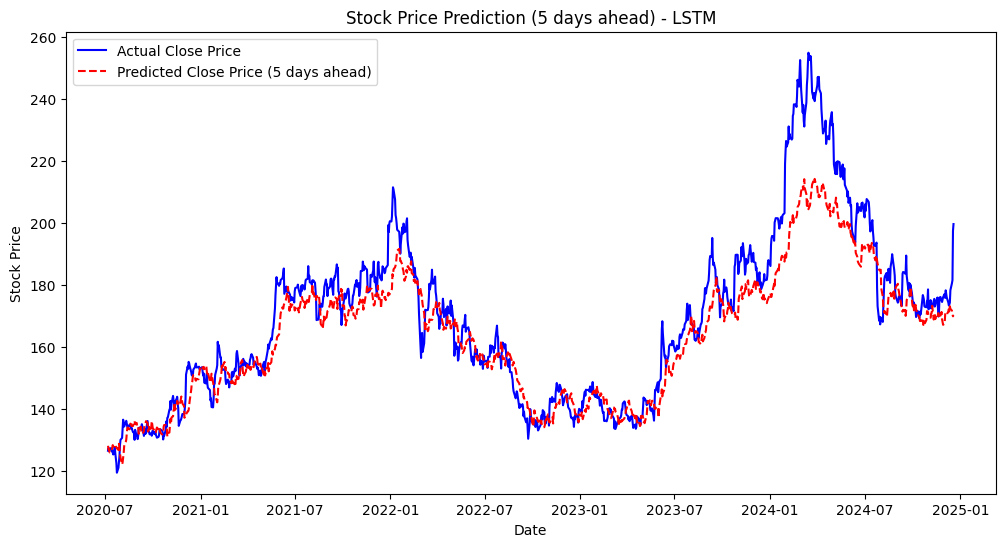

In [93]:
plt.figure(figsize=(12, 6))
plt.plot(df.index[-len(y_test):], Y_test_actual, label="Actual Close Price", color="blue")
plt.plot(df.index[-len(y_pred):], Y_pred, label="Predicted Close Price (5 days ahead)", color="red", linestyle="dashed")
plt.xlabel("Date")
plt.ylabel("Stock Price")
plt.title("Stock Price Prediction (5 days ahead) - LSTM")
plt.legend()
plt.show()

In [94]:
lstm_mae = mean_absolute_error(Y_test_actual, lstm_pred_actual)
lstm_rmse = np.sqrt(mean_squared_error(Y_test_actual, lstm_pred_actual))
print(f"BEST LSTM - MAE: {lstm_mae:.4f}, RMSE: {lstm_rmse:.4f}")

BEST LSTM - MAE: 9.9441, RMSE: 13.3185


NO PROGRESS IN HYPERTUNING

### ARIMA

In [38]:
data = df['Close_+5d']

In [39]:
from statsmodels.tsa.stattools import adfuller

# ADF Test for Stationarity
result = adfuller(data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

# If p-value < 0.05, the series is stationary.
# Perform differencing to make data stationary
diff_data = data.diff().dropna()

# Check stationarity again
result = adfuller(diff_data)
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

data = diff_data

ADF Statistic: -0.44201970614066277
p-value: 0.9028430741686084
ADF Statistic: -21.988104117964287
p-value: 0.0


In [40]:
train_size = int(len(data) * 0.8)
train, test = data[:train_size], data[train_size:]

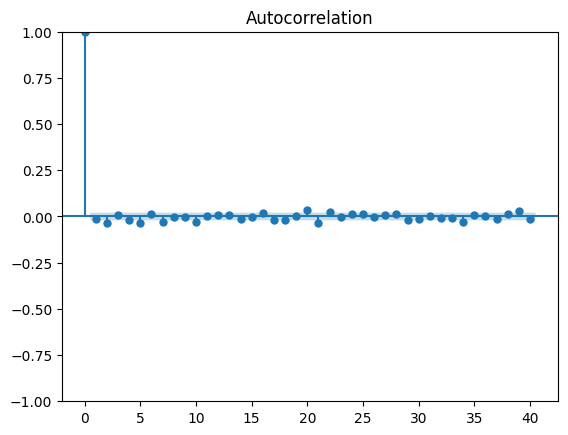

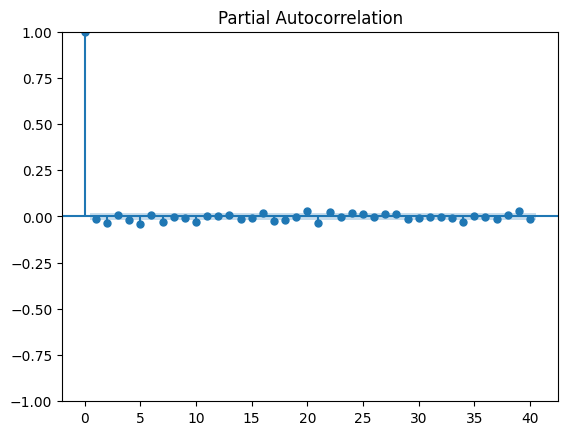

In [41]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF to determine p and q
plot_acf(train)
plot_pacf(train)
plt.show()

In [42]:
from statsmodels.tsa.arima.model import ARIMA

p, d, q = 1, 1, 1

arima_model = ARIMA(train, order=(p, d, q))
arima_model_fit = arima_model.fit()

print(arima_model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:              Close_+5d   No. Observations:                 9026
Model:                 ARIMA(1, 1, 1)   Log Likelihood              -13391.396
Date:                Mon, 10 Mar 2025   AIC                          26788.792
Time:                        00:21:32   BIC                          26810.116
Sample:                    03-20-1980   HQIC                         26796.047
                         - 12-04-2004                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0150      0.006     -2.533      0.011      -0.027      -0.003
ma.L1         -1.0000      0.005   -193.219      0.000      -1.010      -0.990
sigma2         1.1374      0.009    129.200      0.0

#### forecast vs actual values

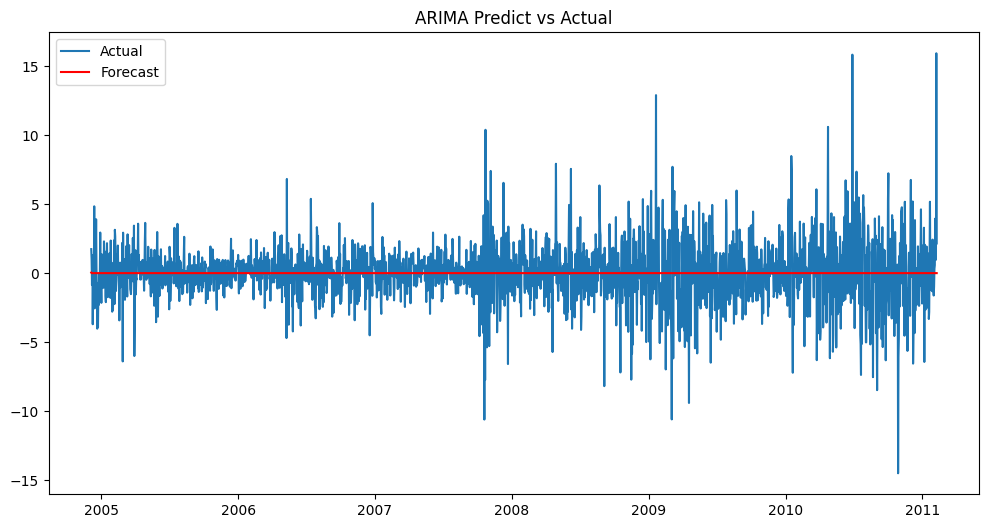

In [43]:
forecast = arima_model_fit.forecast(steps=len(test))

plt.figure(figsize=(12, 6))
plt.plot(test.index, test, label='Actual')
plt.plot(test.index, forecast, label='Forecast', color='red')
plt.legend()
plt.title("ARIMA Predict vs Actual")
plt.show()

In [44]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

mae = mean_absolute_error(test, forecast)
print(f"MAE: {mae}")
rmse = np.sqrt(mean_squared_error(test, forecast))
print(f"RMSE: {rmse}")

MAE: 1.5062907321051562
RMSE: 2.168930472741488
